# Working with Python and Pandas


  - [Importing csv Files](#csv)
  - [DateTime Objects](#dt)
  - [Plotting and Charting](#plots)
  - [Maps](#maps)
  - [Reading Excel Files in Python](#excel)

<a id='csv'></a>
## Importing CSV files

In [1]:
import numpy as np
import pandas as pd
import re
import json
import gmaps
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# https://data.austintexas.gov/Public-Safety/EMS-Spring-Festival-Season-2018-Incident-Details/q99r-2je5
# https://data.austintexas.gov/resource/ddqt-6p93.json
# SXSW 2018 was 3/9 - 3/18
ems = pd.read_csv('./ems.csv')

In [3]:
ems.head()

,Incident Key,Event Date,Event Day of Week,Incident Time,Location Longitude,Location Latitude,Responding Units,Dispositions,Transport Priorities,Patient Transports,Patient Refusals,Other Patient Outcomes,Total Patients,Patients Transported to CCP,Patients Transported From CPP,Incident Location,Current
0,1,03/13/2018,Tuesday,03/13/2018 03:00:00 PM,-97.739335,30.267068,SRU3,No Patient,NaN,0,0,0,0,0,0,"(30.267068, -97.739335)",NaN
1,2,03/13/2018,Tuesday,03/13/2018 04:00:00 PM,-97.738247,30.266782,"CCP1, SRU1, SRU3",Refusal,NaN,0,0,0,0,1,0,"(30.266782, -97.738247)",NaN
2,3,03/13/2018,Tuesday,03/13/2018 04:00:00 PM,-97.739335,30.267068,"CCP2, MTRC5, SRU5",Refusal,NaN,0,2,0,2,1,0,"(30.267068, -97.739335)",NaN
3,4,03/13/2018,Tuesday,03/13/2018 04:00:00 PM,-97.738025,30.267401,"CHP02, MCOT01, SRU3",No Patient,NaN,0,0,0,0,0,0,"(30.267401, -97.738025)",NaN
4,7,03/13/2018,Tuesday,03/13/2018 05:00:00 PM,-97.739313,30.267062,SRU1,Refusal,NaN,0,0,0,0,0,0,"(30.267062, -97.739313)",NaN


<a id='dt'></a>
## Changing to a DateTime Object

In [4]:
ems['datetime'] = pd.to_datetime(ems['Incident Time'])

In [5]:
ems['datetime'].head()

0   2018-03-13 15:00:00
1   2018-03-13 16:00:00
2   2018-03-13 16:00:00
3   2018-03-13 16:00:00
4   2018-03-13 17:00:00
Name: datetime, dtype: datetime64[ns]

Extract the day of the week from the date using `.dt.dayofweek`

In [6]:
ems['datetime'].dt.dayofweek.head(15)

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     2
10    2
11    2
12    2
13    2
14    2
Name: datetime, dtype: int64

Converting those day-of-week numbers into string values with dictionaries and `.apply()`

In [7]:
week_lookup = {
    0 : 'Mon',
    1 : 'Tue',
    2 : 'Wed',
    3 : 'Thurs',
    4 : 'Fri',
    5 : 'Sat',
    6 : 'Sun'
}

Using our dictionary, we can 'look up' our weekdays by our numbers

In [8]:
# mon = 0, sun = 6
ems.groupby(ems['datetime'].dt.dayofweek.apply(lambda x: week_lookup[x]), sort=False).size()

datetime
Tue       9
Wed      15
Thurs    20
Fri      33
Sat      45
Sun      19
dtype: int64

For charting, let's use a number instead since it can be easily sorted

In [9]:
ebd = ems.groupby(ems['datetime'].dt.dayofweek, sort=True).size()
ebd

datetime
1     9
2    15
3    20
4    33
5    45
6    19
dtype: int64

Next, let's get our events by hour

In [10]:
ebh = ems.groupby(ems['datetime'].dt.hour).size().to_dict()
ebh

{0: 18,
 1: 19,
 2: 12,
 14: 1,
 15: 7,
 16: 20,
 17: 10,
 18: 5,
 19: 6,
 20: 17,
 21: 10,
 22: 5,
 23: 11}

Here's a helper function which fills any any nulls for hours with zeroes and returns a list.

In [11]:
# make an empty dict of zeroes
ebh_dict = dict()
for i in range(0,24):
    ebh_dict[i] = 0

# fill in the dict with our events by hour
for k,v in ebh.items():
    ebh_dict[k] = v
    
# make a tidy list of events by hour
ebh = list(ebh_dict.values())

#cleanup
ebh_dict = None

# final events by hour list
print(ebh)

[18, 19, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 20, 10, 5, 6, 17, 10, 5, 11]


<a id='plots'></a>
## Plotting within a notebook

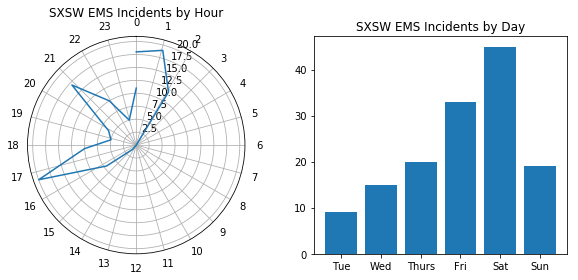

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(10)

for i, ax in enumerate(axes):
    # graph on the left
    if i == 0:
        ax = plt.subplot(121, polar=True)
        equals = np.linspace(0, 360, 24, endpoint=False)
        ones = np.ones(24)
        ax.plot(np.linspace(0,2*np.pi,num=24), ebh)    

        # Set the circumference labels
        ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
        ax.set_xticklabels(range(24))      

        # Make the labels go clockwise
        ax.set_theta_direction(-1)       

        # Place 0 at the top
        ax.set_theta_offset(np.pi/2.0) 
        ax.set_title('SXSW EMS Incidents by Hour', va='bottom')
    # graph on the right:
    if i == 1:
        ax.set_title('SXSW EMS Incidents by Day')
        ax.bar(ebd.index.tolist(), ebd.values.tolist())
        ax.set_xticklabels(['foo'] + [week_lookup[x] for x in ebd.index.tolist()])
   
plt.plot();

<a id='maps'></a>
## Charting Stuff on a Map

First, let's extract our latitude and longitude from our original dataframe

In [13]:
ems['lat'] = ems['Incident Location'].apply(lambda x: float(re.findall(r'-?\d+.\d+', x)[0]))
ems['lon'] = ems['Incident Location'].apply(lambda x: float(re.findall(r'-?\d+.\d+', x)[1]))

In [14]:
ems[['lat', 'lon']].head()

,lat,lon
0,30.267068,-97.739335
1,30.266782,-97.738247
2,30.267068,-97.739335
3,30.267401,-97.738025
4,30.267062,-97.739313


Make a swaet mhap

In [15]:
with open("./constants.json") as f:
    data = f.read()
    api_key = json.loads(data)['key']

gmaps.configure(api_key=api_key)
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(ems[['lat', 'lon']], weights=ems['Total Patients']))
fig

Figure(layout=FigureLayout(height='420px'))

<a id='excel'><a>
## Optional: Read in the Same EMS Dataset as an `.xlsx`

In [16]:
emsx = pd.read_excel('./ems.xlsx')
emsx.head(3)

,Incident Key,Event Date,Event Day of Week,Incident Time,Location Longitude,Location Latitude,Responding Units,Dispositions,Transport Priorities,Patient Transports,Patient Refusals,Other Patient Outcomes,Total Patients,Patients Transported to CCP,Patients Transported From CPP,Incident Location,Current
0,1,2018-03-13,Tuesday,2018-03-13 15:00:00,-97.739335,30.267068,SRU3,No Patient,NaN,0,0,0,0,0,0,"(30.267068, -97.739335)",NaN
1,2,2018-03-13,Tuesday,2018-03-13 16:00:00,-97.738247,30.266782,"CCP1, SRU1, SRU3",Refusal,NaN,0,0,0,0,1,0,"(30.266782, -97.738247)",NaN
2,3,2018-03-13,Tuesday,2018-03-13 16:00:00,-97.739335,30.267068,"CCP2, MTRC5, SRU5",Refusal,NaN,0,2,0,2,1,0,"(30.267068, -97.739335)",NaN


### We can also export our modified dataframe to excel using `pd.DataFrame.to_excel()`

In [23]:
# emsx.to_excel('./output.xlsx')